In [1]:
!pip install -q transformers datasets torch transformers[torch]


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# VQA Training

In [4]:
model_checkpoint = "dandelin/vilt-b32-mlm"

In [5]:
from datasets import load_dataset

# dataset = load_dataset("Graphcore/vqa", split="validation[:200]")
train_dataset = load_dataset("YOUR_HF_ACCOUNT/coco_vqa_small_dataset", split="train[:10]", use_auth_token=True, trust_remote_code=True)

train_dataset

/usr/local/lib/python3.8/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


Dataset({
    features: ['question', 'question_type', 'question_id', 'image_id', 'answer_type', 'label'],
    num_rows: 10
})

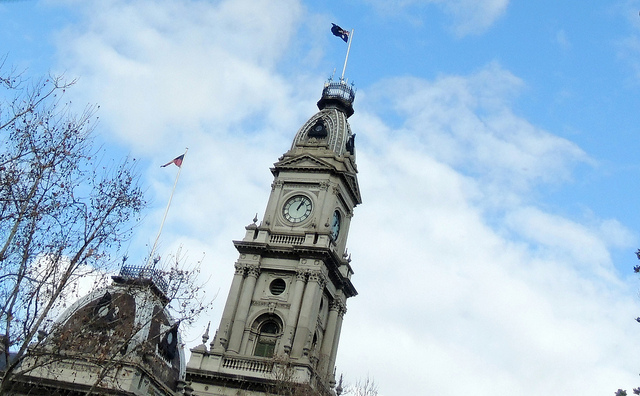

In [6]:
from PIL import Image

image = Image.open(train_dataset[0]['image_id'])
image

In [7]:
import itertools

labels = [item['ids'] for item in train_dataset['label']]
flattened_labels = list(itertools.chain(*labels))
unique_labels = list(set(flattened_labels))

label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()} 

In [8]:
def replace_ids(inputs):
  inputs["label"]["ids"] = [label2id[x] for x in inputs["label"]["ids"]]
  return inputs


train_dataset = train_dataset.map(replace_ids)
flat_dataset = train_dataset.flatten()
flat_dataset.features

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

{'question': Value(dtype='string', id=None),
 'question_type': Value(dtype='string', id=None),
 'question_id': Value(dtype='int32', id=None),
 'image_id': Value(dtype='string', id=None),
 'answer_type': Value(dtype='string', id=None),
 'label.ids': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'label.weights': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [9]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained(model_checkpoint)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
import torch
import os
from PIL import Image

def preprocess_data(examples):
    image_paths = examples['image_id']
    #images = [Image.open(image_path) for image_path in image_paths]
    images = []
    for image_path in image_paths:
        if os.path.exists(image_path):
            try:
                img = Image.open(image_path).convert("RGB")
                images.append(img)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
                images.append(Image.new('RGB', (224, 224)))  # Fallback to dummy image
        else:
            print(f"Image not found: {image_path}")
            images.append(Image.new('RGB', (224, 224)))  # Fallback to dummy image

    texts = examples['question']    

    encoding = processor(images, texts, padding="max_length", truncation=True, return_tensors="pt")

    for k, v in encoding.items():
          encoding[k] = v.squeeze()
    targets = []

    for labels, scores in zip(examples['label.ids'], examples['label.weights']):
        target = torch.zeros(len(id2label))

        for label, score in zip(labels, scores):
            target[label] = score
        targets.append(target)

    encoding["labels"] = targets
    return encoding

In [11]:
processed_dataset = flat_dataset.map(preprocess_data, batched=True, remove_columns=['question','question_type',  'question_id', 'image_id', 'answer_type', 'label.ids', 'label.weights'])
processed_dataset

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'],
    num_rows: 10
})

In [12]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="vilt_finetuned_1_epoch",
    per_device_train_batch_size=1,
    num_train_epochs=1,
    save_steps=200,
    logging_steps=50,
    learning_rate=5e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

In [14]:
from transformers import ViltForQuestionAnswering

model = ViltForQuestionAnswering.from_pretrained(model_checkpoint, num_labels=len(id2label), id2label=id2label, label2id=label2id)

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed_dataset,
    tokenizer=processor,
)

In [16]:
trainer.train() 

Step,Training Loss


TrainOutput(global_step=10, training_loss=22.577738952636718, metrics={'train_runtime': 5.2991, 'train_samples_per_second': 1.887, 'train_steps_per_second': 1.887, 'total_flos': 214463779200.0, 'train_loss': 22.577738952636718, 'epoch': 1.0})

In [17]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

events.out.tfevents.1715789610.arg10.1553.0:   0%|          | 0.00/6.47k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/SIS-2024-spring/vilt_finetuned_1_epoch/commit/c4cc67ce0c65926a3d9bc42e96e3e782c5d9f77a', commit_message='End of training', commit_description='', oid='c4cc67ce0c65926a3d9bc42e96e3e782c5d9f77a', pr_url=None, pr_revision=None, pr_num=None)

In [18]:
# VQA Inference

In [19]:
from transformers import pipeline

pipe = pipeline("visual-question-answering", model="YOUR_HF_ACCOUNT/vilt_finetuned_1_epoch")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

In [20]:
val_dataset = load_dataset("YOUR_HF_ACCOUNT/coco_vqa_small_dataset", split="validation[:10]", use_auth_token=True, trust_remote_code=True)
example = val_dataset[0]
example 

/usr/local/lib/python3.8/dist-packages/datasets/load.py:2547: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(


{'question': 'What is this place?',
 'question_type': 'what is this',
 'question_id': 377626002,
 'image_id': 'vqa-images/COCO_val2014_000000377626.jpg',
 'answer_type': 'other',
 'label': {'ids': ['farmers market', 'market', 'public market center'],
  'weights': [1.0, 0.30000001192092896, 0.6000000238418579]}}

In [21]:
image = Image.open(example['image_id'])
question = example['question']
print(question)
pipe(image, question, top_k=1)

What is this place?


[{'score': 0.6395970582962036, 'answer': 'bus'}]

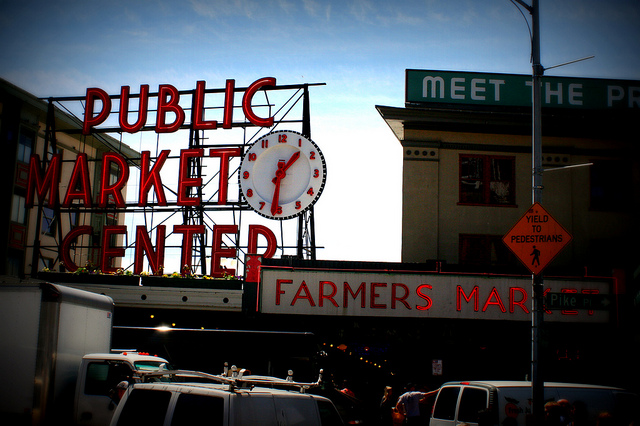

In [22]:
processor = ViltProcessor.from_pretrained("YOUR_HF_ACCOUNT/vilt_finetuned_1_epoch")

image = Image.open(example['image_id'])
image

In [23]:
question = example['question']
question

'What is this place?'

In [27]:
# prepare inputs
inputs = processor(image, question, return_tensors="pt")

model = ViltForQuestionAnswering.from_pretrained("YOUR_HF_ACCOUNT/vilt_finetuned_1_epoch")

# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
idx = logits.argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: bus


In [28]:
# Zero-Shot VQA Inference (optional)

In [29]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

In [30]:
example = val_dataset[0]
image = Image.open(example['image_id'])
question = example['question']
prompt = f"Question: {question} Answer:" 
prompt

'Question: What is this place? Answer:'

In [31]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=10)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

Both `max_new_tokens` (=10) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Public Market Center
